<a href="https://colab.research.google.com/github/danielzt12/AD_LTEM/blob/main/AD_LTEM_sim_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
!git clone https://github.com/danielzt12/AD_LTEM

Cloning into 'AD_LTEM'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 84 (delta 40), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (84/84), done.


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import signal as tfs
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys, time
from scipy.fftpack import *
from skimage.restoration import unwrap_phase, denoise_tv_chambolle
from scipy import ndimage
from google.colab import output
import tifffile as tif
import gdown

sys.path.append("AD_LTEM")

from torch.cuda import get_device_name
print("GPU:", get_device_name(0))

GPU: Tesla T4


In [3]:
# truth for amplitude and phase

true_amplitude =  tif.imread('AD_LTEM/design_amp.tiff')
true_phase = tif.imread('AD_LTEM/design_tphi.tiff')
true_phase -= true_phase.mean()

In [4]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 10
# there are 65 defocus images equally distributed between -1.6 mm and 1.6 mm
defocus = np.linspace(-1.6e6,1.6e6,65)

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise from transparent region : {0:.1f}%".format(A_samples[:,280:320,280:320].std()*200))

Downloading...
From: http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk
To: /content/amplitude4TIE_noise10.npy
136MB [00:01, 122MB/s]
estimated noise from transparent region : 11.8%


Text(0.5, 1.0, '1600000.0 nm')

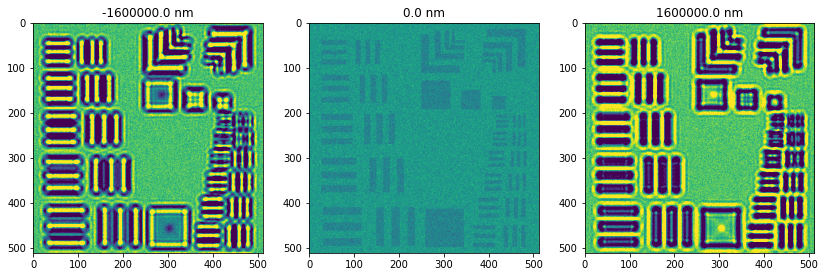

In [5]:
f, ax = plt.subplots(ncols=3, figsize = (14,8))
ax[0].imshow(A_samples[0], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[0].set_title("{0} nm".format(defocus[0]))
ax[1].imshow(A_samples[32], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[1].set_title("{0} nm".format(defocus[32]))
ax[2].imshow(A_samples[64], cmap='viridis', norm=colors.Normalize(A_samples[32].min(), A_samples[32].max()))
ax[2].set_title("{0} nm".format(defocus[64]))

In [6]:
# generate microscopic transfer function

from microscopes_fwd import Microscope

defocus = np.linspace(-1.6e6,1.6e6,65)

#inititiate microscope class
TEM = Microscope(Cs = 1.0e6, theta_c = 0.01e-3, def_spr = 500)

#reciprocal space vectors
[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

# define pixel resolution in nm.
del_px = 5 #nm/px

tf_microscope = np.zeros(A_samples.shape, dtype=np.complex128)
DampEnvs = np.zeros(A_samples.shape, dtype=np.float64)

for i in range(defocus.shape[0]):
  TEM.defocus = defocus[i]
  tf_microscope[i] = TEM.getTransferFunction(qq, del_px)
  DampEnvs[i] =  TEM.getDampEnv(qq, del_px)

#A_samples /= A_samples.mean(1).mean(1)[:,np.newaxis,np.newaxis]

# AD Phase Retrieval without regularizer

In [ ]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 14

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise from transparent region : {0:.1f}%".format(A_samples[:,280:320,280:320].std()*200))

Downloading...
From: http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf
To: /content/amplitude4TIE_noise14.npy
136MB [00:01, 96.0MB/s]


In [ ]:
selection = [28,30,62,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]

chosen defocus (mm):  [-0.2 -0.1  1.5  1.6]


In [ ]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*TF)

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2)

  gerr = losses
  return losses


In [ ]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  accs = []

  for i in range(max_iter):
    opt = tf.optimizers.Adam(learning_rate=lr)
    train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    result_phase = guess_phase.numpy()
    result_phase = unwrap_phase(result_phase)
    result_phase -= result_phase.mean()
    acc = (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum())
    accs.append(acc)
    errs.append(gerr.numpy())
    if i>10:
      if np.abs(errs[-1]-errs[-2]) < tol:
        break

  return result_phase, np.array(errs), np.array(accs), i

In [ ]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

In [ ]:
tot_errs = []
tot_accs = []

lr = .8
max_iter = 10000
t1=time.time()
result=optimize(1e-9,max_iter=max_iter,lr=lr)
t2=time.time()
print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[3]))
print("final err {0}".format(result[1][-1]))
print("final acc {0:.3f} ".format(result[2][-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(result[2].max(), result[2].argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

total elapsed time 384.0 s for 2958 iterations: 
final err 0.004006078001111746
final acc 0.956 
max acc 0.956 at iteration #2958: 


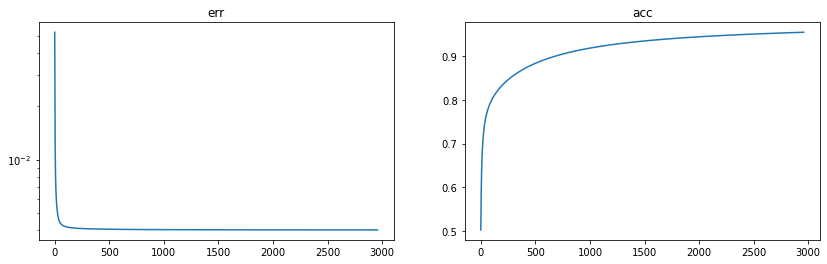

In [ ]:
f, ax = plt.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(result[1])
ax[0].set_title("err")
ax[1].plot(result[2])
ax[1].set_title("acc");

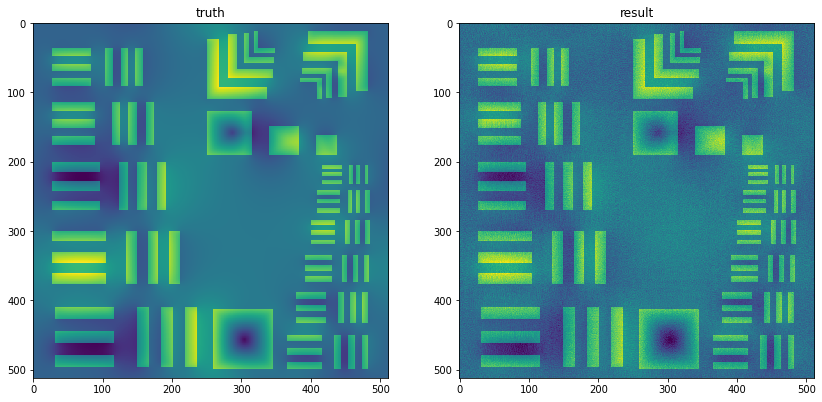

In [ ]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result[0], interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

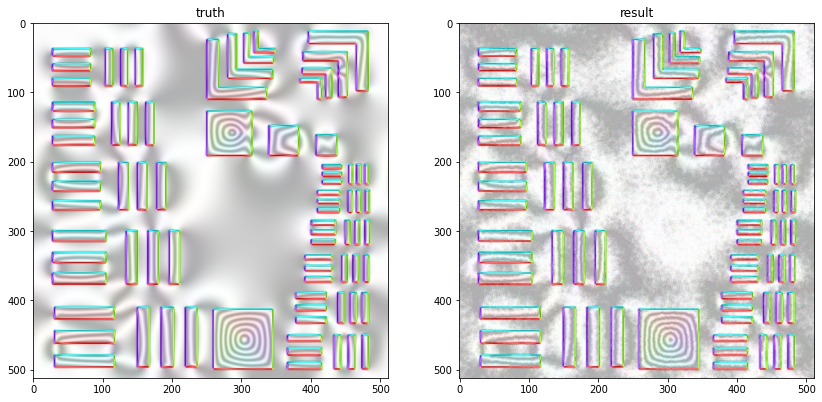

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),1,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

# AD Phase Retrieval With Total Variation Regularizer

In [38]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 10

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise from transparent region : {0:.1f}%".format(A_samples[:,280:320,280:320].std()*200))

Downloading...
From: http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk
To: /content/amplitude4TIE_noise10.npy
136MB [00:00, 141MB/s]
estimated noise from transparent region : 11.8%


In [39]:
selection = [0,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection], axes=(1,2))
exp_data = A_samples[selection]

chosen defocus (mm):  [-1.6  1.6]


In [40]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*TF)

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2) + lamb*tf.image.total_variation(tf.expand_dims(guess_phase,axis=-1))

  gerr = losses
  return losses


In [41]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  accs = []

  for i in (range(max_iter)):
    opt = tf.optimizers.Adam(learning_rate=lr)
    train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    result_phase = guess_phase.numpy()
    result_phase = unwrap_phase(result_phase)
    result_phase -= result_phase.mean()
    acc = (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum())
    accs.append(acc)
    errs.append(gerr.numpy())
    if i>10:
      if np.abs(errs[-1]-errs[-2]) < tol:
        break
    i += 1

  return result_phase, np.array(errs), np.array(accs), i

In [42]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

In [43]:
tot_errs = []
tot_accs = []

lr = .8
lamb = 4e-8
max_iter = 20000
t1=time.time()
result=optimize(1e-10,max_iter=max_iter,lr=lr)
t2=time.time()
print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[3]))
print("final err {0}".format(result[1][-1]))
print("final acc {0:.3f} ".format(result[2][-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(result[2].max(), result[2].argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

total elapsed time 608.5 s for 5029 iterations: 
final err 0.004025930538773537
final acc 0.997 
max acc 0.997 at iteration #5024: 


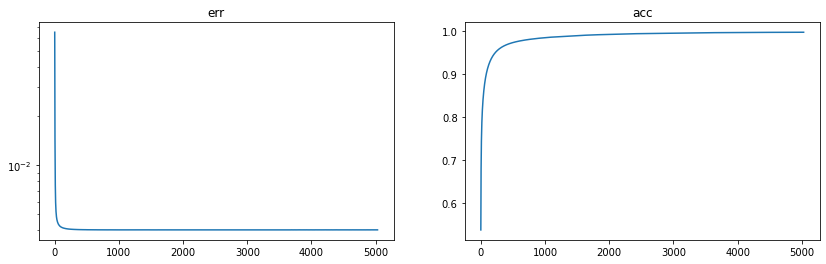

In [44]:
f, ax = plt.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(result[1])
ax[0].set_title("err")
ax[1].plot(result[2])
ax[1].set_title("acc");

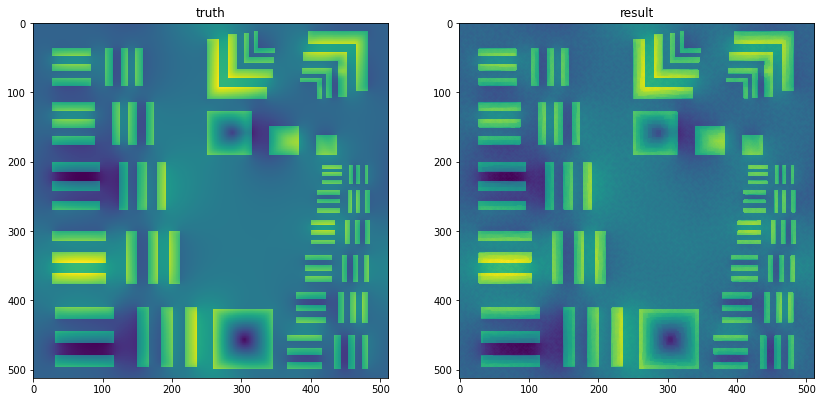

In [45]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result[0], interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

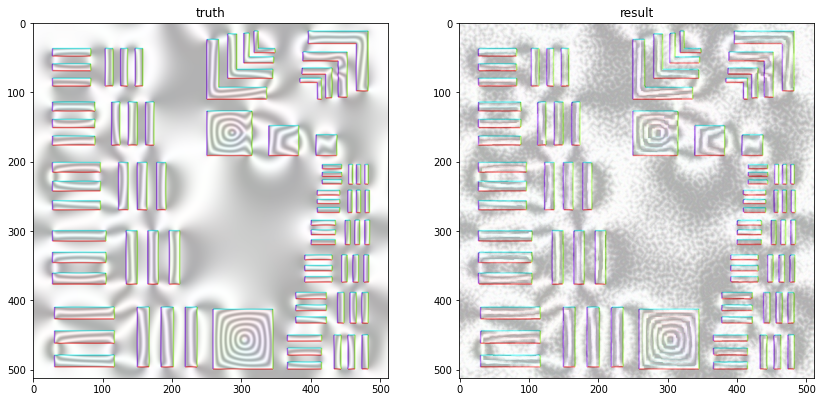

In [46]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),0,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result[0])
t2=ndimage.gaussian_filter(t2-np.mean(t2),0,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

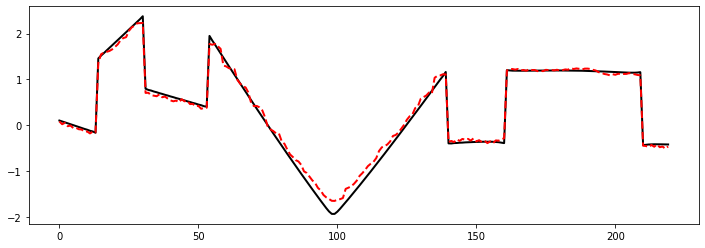

In [47]:
fig, ax = plt.subplots(figsize=(12,4))
ax.plot((true_phase-true_phase.mean())[457,205:425], 'k-', linewidth=2)

ax.plot((result[0])[457,205:425], 'r--', linewidth=2)

# Iterative Phase Retrieval with Gerchberg-Saxton

In [ ]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 0

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise from transparent region : {0:.1f}%".format(A_samples[:,280:320,280:320].std()*200))

Downloading...
From: http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R
To: /content/amplitude4TIE_noise0.npy
136MB [00:00, 182MB/s]
estimated noise from transparent region : 5.0%


In [ ]:
selection = [28,30,40,42]
print("chosen defocus (mm): ", defocus[selection]/1e6)

TF = fftshift(tf_microscope[selection]/DampEnvs[selection], axes=(1,2))
exp_data = A_samples[selection]
DE = fftshift(DampEnvs[selection], axes=(1,2))
DE2 = DE>1e-13

chosen defocus (mm):  [-0.2 -0.1  0.4  0.5]


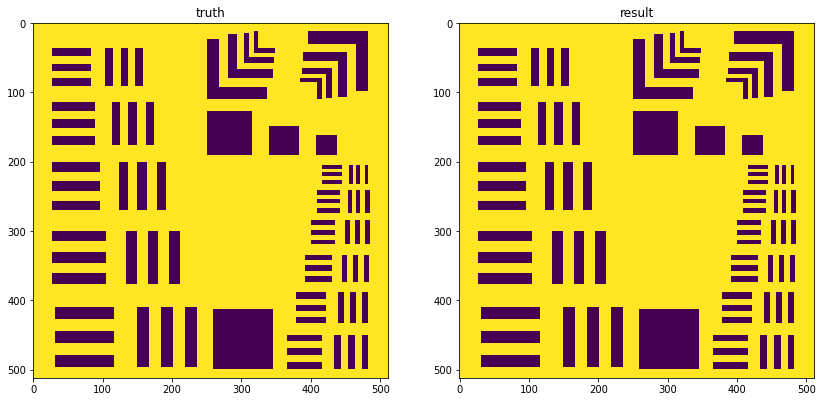

In [ ]:
# to show reversibility of the propagation 
guess_amplitude = np.copy(true_amplitude)
guess_phase = np.copy(true_phase)
ObjWave = guess_amplitude * np.exp(1j*guess_phase)
f, ax = plt.subplots(ncols=2, figsize = (14,8))
tt = ifft2(fft2(ObjWave)*TF[-1]*DE[-1])
tt = ifft2(fft2(tt)*np.conj(TF[-1]/DE[-1]*DE2[-1]))

ax[0].imshow(np.abs(tt), interpolation='none', norm=colors.Normalize(np.abs(ObjWave).min(),np.abs(ObjWave).max()))
ax[0].set_title("truth")
ax[1].imshow(np.abs(ObjWave), interpolation='none', norm=colors.Normalize(np.abs(ObjWave).min(),np.abs(ObjWave).max()))
ax[1].set_title("result");

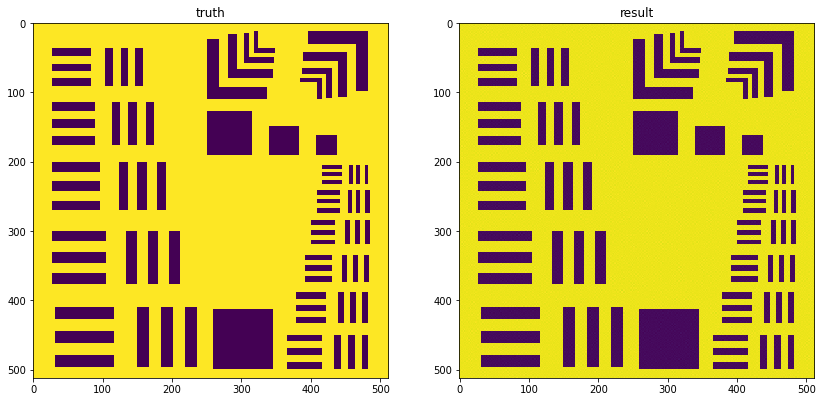

In [ ]:
# to show reversibility of the propagation 
guess_amplitude = np.copy(true_amplitude)
guess_phase = np.copy(true_phase)
ObjWave = guess_amplitude * np.exp(1j*guess_phase)
f, ax = plt.subplots(ncols=2, figsize = (14,8))
tt = ifft2(fft2(ObjWave)*TF[-1]*DE[-1])
tt = (np.abs(tt)+np.abs(tt)*np.random.random(tt.shape)*0.0001) * np.exp(1j*np.angle(tt))
tt = ifft2(fft2(tt)*np.conj(TF[-1]/DE[-1]*DE2[-1]))

ax[0].imshow(np.abs(ObjWave), interpolation='none', norm=colors.Normalize())
ax[0].set_title("truth")
ax[1].imshow(np.abs(tt), interpolation='none', norm=colors.Normalize(np.abs(tt).min(), np.abs(tt).max()))
ax[1].set_title("result");

In [ ]:
# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
#guess_amplitude = denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False)
guess_amplitude = np.copy(true_amplitude)
# initialize the phase as 0.5 everywhere
#guess_phase = np.zeros(A_samples[32].shape)+0.5
guess_phase = np.copy(true_phase)

In [ ]:
ObjWave = guess_amplitude * np.exp(1j*guess_phase)

acc = []
err = []

maxiter = 20
t1 = time.time()
tol = 1e-9

t1 = time.time()

for i in range(maxiter):

  ImgWave = ifft2(fft2(ObjWave)*TF*DE)
  err.append(((np.abs(ImgWave)/np.abs(ImgWave).mean(1).mean(1)[:,np.newaxis,np.newaxis]-exp_data)**2).mean())
  ImgWave = ImgWave / np.abs(ImgWave) * exp_data
  #          ------  back propagation  -------  weighted sum
  #ObjWave = ifft2(fft2(ImgWave)/DE*np.conj(TF)).sum(0) / DE.sum(0)
  #          simple average of all backpropagated images
  #ObjWave = ifft2(fft2(ImgWave)*np.conj(TF)).mean(0)
  #ObjWave = ifft2(fft2(ImgWave)*np.conj(TF/DE*DE2)).mean(0)
  ObjWave = ifft2( (fft2(ImgWave)*np.conj(TF)).mean(0) )
  result_phase = np.angle(ObjWave)
  result_phase = unwrap_phase(result_phase)
  result_phase -= result_phase.mean()
  acc.append( (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum()) )
  if i>10:
    #if np.abs(err[-1]-err[-2]) < tol:
    #  break
    #if not i%100:
    print(err[-1]-err[-2], acc[-1])
  ObjWave = guess_amplitude * np.exp(1j*result_phase)

t2=time.time()
err = np.array(err)
acc = np.array(acc)

print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,i))
print("final err {0}".format(err[-1]))
print("final acc {0:.3f} ".format(acc[-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(acc.max(), acc.argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

5.32208048847696e-05 0.9856385952098389
4.552126177281932e-05 0.9854247721920079
3.944357076261871e-05 0.9852333842720805
3.4572387439777384e-05 0.985060297183558
3.061556238524634e-05 0.9849022688769917
2.7362133267162456e-05 0.984756746202369
2.4656650773851978e-05 0.9846217108328132
2.238273285779316e-05 0.9844955609711884
2.0452115422615706e-05 0.9843770199074815
total elapsed time 5.1 s for 19 iterations: 
final err 0.004778372914478457
final acc 0.984 
max acc 0.996 at iteration #0: 


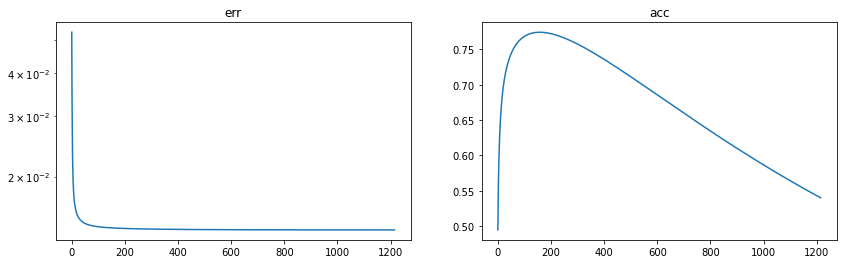

In [ ]:
f, ax = plt.subplots(ncols=2, figsize = (14,4))
ax[0].semilogy(err)
ax[0].set_title("err")
ax[1].plot(acc)
ax[1].set_title("acc");

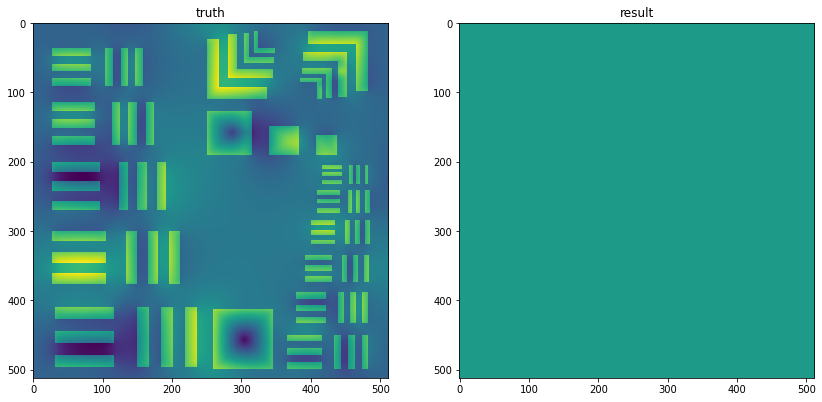

In [ ]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

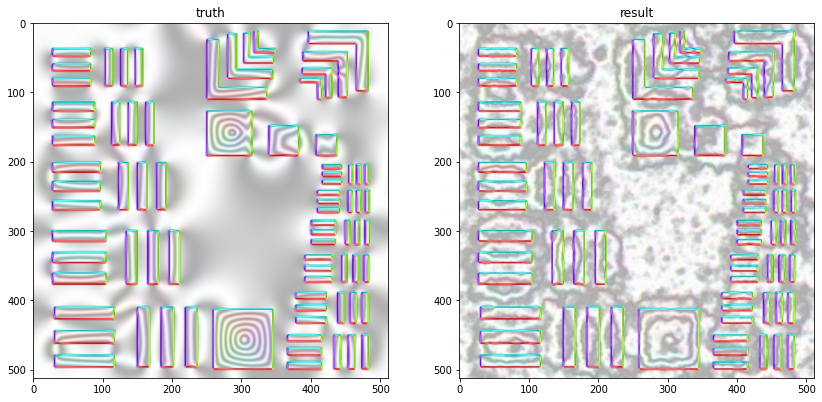

In [ ]:
from microscopes_fwd import Plot_ColorMap

# show phase gradient
f, ax = plt.subplots(ncols=2, figsize = (14,8))

t1 = np.copy(true_phase)
t1=ndimage.gaussian_filter(t1-np.mean(t1),1,order=0)
gx=np.gradient(t1,axis=0)
gy=np.gradient(t1,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[0].imshow(rgb_map)
ax[0].set_title("truth")
ax[0].imshow(np.cos(t1*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)

t2 = np.copy(result_phase)
t2=ndimage.gaussian_filter(t2-np.mean(t2),1,order=0)
gx=np.gradient(t2,axis=0)
gy=np.gradient(t2,axis=1)
rgb_map=Plot_ColorMap(Bx=gx, By=gy, hsvwheel=True)
ax[1].imshow(rgb_map)
ax[1].imshow(np.cos(t2*10), cmap=plt.cm.gray, alpha=.3, vmin=-1, vmax=1)
ax[1].set_title("result");

# Partial Probe Retrieval with AD

In [ ]:
# load pre-generated data set, the stored values are the square root of the intensities already
noise = 14

if noise == 0:
  !gdown "http://drive.google.com/uc?id=1-QUqVhxKKhgqr9A7Q98cLslFIcVCvm4R"
  A_samples = np.load("amplitude4TIE_noise0.npy")
elif noise == 5:
  !gdown "http://drive.google.com/uc?id=11X3ZvbEF3tuKV1hmYL_lDJIi1YShgms4"
  A_samples = np.load("amplitude4TIE_noise5.npy")
elif noise == 10:
  !gdown "http://drive.google.com/uc?id=1-MZs7i4g4C6D5IMFSdJLmhbiVchNgVtk"
  A_samples = np.load("amplitude4TIE_noise10.npy")
elif noise == 14:
  !gdown "http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf"
  A_samples = np.load("amplitude4TIE_noise14.npy")
elif noise == 15:
  !gdown "http://drive.google.com/uc?id=127oLeaAGk-g3asVcLNWvUkQZGZRYl30l"
  A_samples = np.load("amplitude4TIE_noise15.npy")
elif noise == 20:
  !gdown "http://drive.google.com/uc?id=10tD8eOdh9MmTl5SpoetrMbWhN7lFz_iv"
  A_samples = np.load("amplitude4TIE_noise20.npy")
elif noise == 30:
  !gdown "http://drive.google.com/uc?id=1-x4sOUgUJVgrCADYwUpEqRQwuyMOJLca"
  A_samples = np.load("amplitude4TIE_noise30.npy")
elif noise == 40:
  !gdown "http://drive.google.com/uc?id=15yC64QAoWNDd6bSDd7_7lCa-Ic4ztgxA"
  A_samples = np.load("amplitude4TIE_noise40.npy")

print("estimated noise from transparent region : {0:.1f}%".format(A_samples[:,280:320,280:320].std()*200))

Downloading...
From: http://drive.google.com/uc?id=1460lrCxB2bwzG38q17QhI03RclclC1gf
To: /content/amplitude4TIE_noise14.npy
136MB [00:01, 84.3MB/s]
estimated noise from transparent region : 15.8%


In [ ]:
# rewriting the microscope transfer function with tensorflow

import scipy.constants as physcon

[dim,dim] = true_amplitude.shape
d2=dim/2
line = np.arange(dim)-float(d2)
[X,Y] = np.meshgrid(line,line)
qq = np.sqrt(X**2 + Y**2) / float(dim)

del_px = 5 #nm/px

E = 200.0e3
Cs=1.0e6
Cc=5.0e6
Ca=0.0e6
phi_a=0
#def_spr=500.0

epsilon = 0.5 * physcon.e / physcon.m_e / physcon.c**2
lam = physcon.h * 1.0e9 / np.sqrt(2.0 * physcon.m_e * physcon.e) / np.sqrt(E + epsilon * E**2)
gamma = 1.0 + physcon.e * E / physcon.m_e / physcon.c**2
sigma = 2.0 * np.pi * physcon.m_e * gamma * physcon.e * lam * 1.0e-18 / physcon.h**2

lam = lam / del_px
cs = Cs / del_px
ca = Ca / del_px
phi = 0

def getTF(defoc, theta_c, def_spr):

  def_val = defoc / del_px
  spread = def_spr / del_px

  theta_c = tf.math.pow(10, theta_c/20)

  p1 = np.pi * lam * (def_val + ca * np.cos(2.0 * (phi - phi_a))) # tensor
  p2 = np.pi * cs * lam**3 * 0.5
  p3 = 2.0 * (np.pi * theta_c * spread)**2  # a tensor
  p4 = (np.pi * lam * spread)**2 # a tensor
  p5 = np.pi**2 * theta_c**2 / lam**2  # a tensor
  p6 = cs * lam**3
  p7 = def_val * lam  # a tensor
        
  u = 1.0 + p3 * qq**2 # a tensor
  chiq = -p1 * qq**2 + p2 * qq**4
  es_arg = 1.0/(2.0*u) * p4 * qq**4   # a tensor
  et_arg = tf.math.multiply(1.0/u, tf.math.multiply(p5, (p6 * qq**3 - tf.math.multiply(p7,qq) )**2 ) )  # a tensor

  dampenv = tf.cast(tf.exp(es_arg-et_arg), tf.complex64)   # a tensor

  transfer_function = tfs.fftshift(tf.math.multiply(tf.complex(tf.cos(chiq),-tf.sin(chiq)), dampenv), axes=(1,2))

  return transfer_function

In [ ]:
# the loss function

def compute_loss():

  global gerr 

  tf_obj_real = guess_amplitude*tf.math.cos(guess_phase)
  tf_obj_imag = guess_amplitude*tf.math.sin(guess_phase)
  tf_obj = tf.complex(tf_obj_real, tf_obj_imag)

  cal_data = tfs.ifft2d(tfs.fft2d(tf_obj)*getTF(defoc, theta_c, def_spr))

  cal_data = tf.abs(cal_data)
  cal_data /= tf.reduce_mean(cal_data, axis=(1,2), keepdims=True)

  losses = tf.reduce_mean((cal_data - exp_data)**2)

  gerr = losses
  return losses


In [ ]:
# ADAM gradient descent optimization

def optimize(tol=1e-9, max_iter=10000, lr=1):
  err = np.Inf # step error (banach), not actual erro
  i = 0
  errs = []
  accs = []
  theta_cs = []
  def_sprs = []

  for i in range(max_iter):
    opt = tf.optimizers.Adam(learning_rate=lr)
    if i>0 and not i%20: # optimize probe every 20 iterations
        #train = opt.minimize(compute_loss, var_list=[theta_c])
        #theta_cs.append(float(theta_c))
        train = opt.minimize(compute_loss, var_list=[def_spr])
        def_sprs.append(float(def_spr))
    train = opt.minimize(compute_loss, var_list=[guess_phase]) #Optim only over phase
    result_phase = guess_phase.numpy()
    result_phase = unwrap_phase(result_phase)
    result_phase -= result_phase.mean()
    acc = (result_phase*true_phase).sum() / np.sqrt((result_phase*result_phase).sum() * (true_phase*true_phase).sum())
    accs.append(acc)
    errs.append(gerr.numpy())
    if i>10:
      if np.abs(errs[-1]-errs[-2]) < tol:
        break

  return result_phase, np.array(errs), np.array(accs), i, np.array(def_spr)

In [ ]:
selection = [28,30,62,64]
print("chosen defocus (mm): ", defocus[selection]/1e6)

exp_data = A_samples[selection]

# initialize the amplitude as the square root of the on focus image intensity, the optimal weight is known for simulated data, and is estimated for exp data
guess_amplitude = tf.constant(denoise_tv_chambolle(A_samples[32], weight=noise/100./2, multichannel=False), dtype='float32')
# initialize the phase as 0.5 everywhere
guess_phase = tf.Variable(np.zeros(A_samples[32].shape)+0.5, dtype='float32') 

defoc = tf.constant(defocus[selection][:, np.newaxis, np.newaxis], dtype=tf.float32)
theta_c = tf.Variable(-100, dtype=tf.float32)
def_spr = tf.Variable(120, dtype=tf.float32)

chosen defocus (mm):  [-0.2 -0.1  1.5  1.6]


In [ ]:
tot_errs = []
tot_accs = []

lr = .8
max_iter = 3000
t1=time.time()
result=optimize(1e-8,max_iter=max_iter,lr=lr)
t2=time.time()
print("total elapsed time {0:.1f} s for {1:d} iterations: ".format(t2-t1,result[3]))
print("final err {0}".format(result[1][-1]))
print("final acc {0:.3f} ".format(result[2][-1]))
print("max acc {0:.3f} at iteration #{1:d}: ".format(result[2].max(), result[2].argmax()))

output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

total elapsed time 250.9 s for 1301 iterations: 
final err 0.004001884255558252
final acc 0.930 
max acc 0.930 at iteration #1301: 


ValueError: ignored

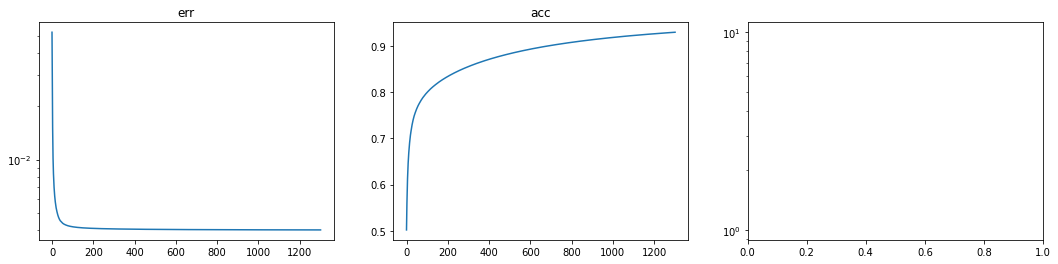

In [ ]:
f, ax = plt.subplots(ncols=3, figsize = (18,4))
ax[0].semilogy(result[1])
ax[0].set_title("err")
ax[1].plot(result[2])
ax[1].set_title("acc");
ax[2].semilogy(np.arange(149)*20,np.power(10,result[-1]/20), '.-')
ax[2].set_title("theta_c");

In [ ]:
print(result[-1])

119.99921


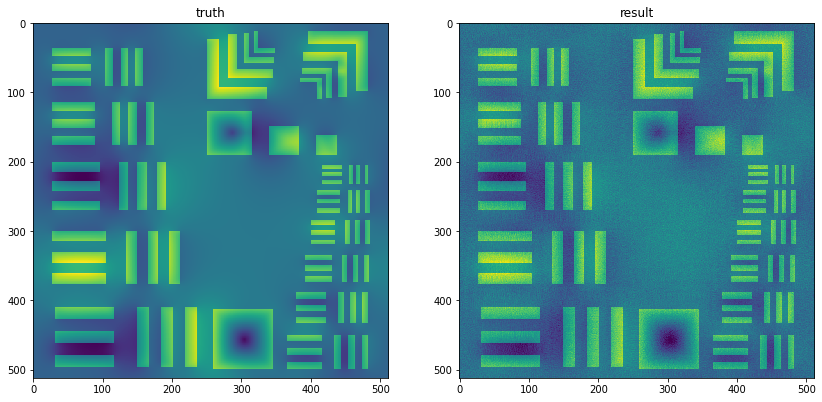

In [ ]:
# show phase
f, ax = plt.subplots(ncols=2, figsize = (14,8))
ax[0].imshow(true_phase, interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[0].set_title("truth")
ax[1].imshow(result[0], interpolation='none', norm=colors.Normalize(true_phase.min(),true_phase.max()))
ax[1].set_title("result");

In [ ]:
print(float(result[-1]))

-5.614205837249756


# Saving

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
path = '/content/drive/My Drive/new_test_data_for_ADLorentz/new_new_paper/'

In [21]:
np.save(path+"29_35_AD_noise10_TV0em8_err.npy", result[1])
np.save(path+"29_35_AD_noise10_TV0em8_acc.npy", result[2])
np.save(path+"29_35_AD_noise10_TV0em8_pha.npy", result[0])

In [26]:
err1 = np.load(path+"29_35_AD_noise10_TV0em8_err.npy")
err2 = np.load(path+"29_35_AD_noise10_TV4em8_err.npy")
acc1 = np.load(path+"29_35_AD_noise10_TV0em8_acc.npy")
acc2 = np.load(path+"29_35_AD_noise10_TV4em8_acc.npy")

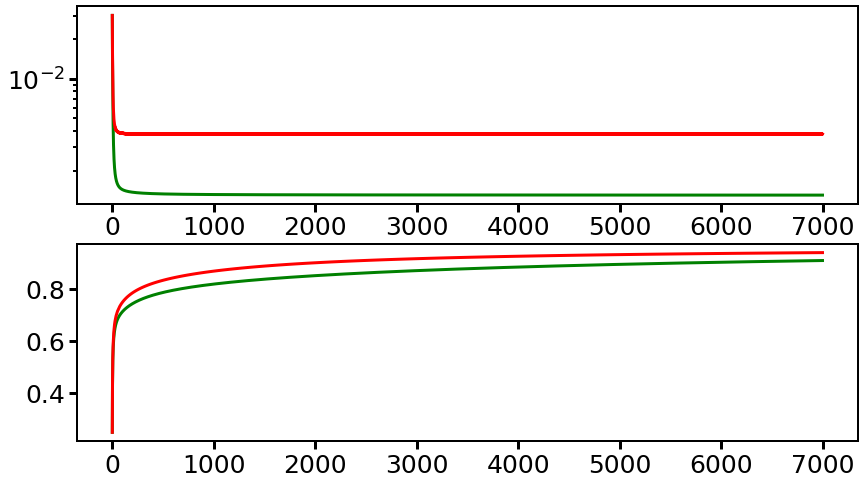

In [37]:
f, ax = plt.subplots(nrows=2, figsize = (14,8))
ax[0].set_xticks(np.arange(0,8000,1000))
ax[0].tick_params(which='major',width=3, length=8, labelsize=25)
ax[0].tick_params(which='minor',width=2, length=4)
for axis in ['top','bottom','left','right']:
  ax[0].spines[axis].set_linewidth(2)
ax[0].semilogy(err1[:7000], 'g', linewidth=3)
ax[0].semilogy(err2[:7000], 'r', linewidth=3)
ax[1].set_xticks(np.arange(0,8000,1000))
ax[1].set_yticks(np.arange(0.2,1,0.2))
ax[1].tick_params(width=3, length=8, labelsize=25)
ax[1].plot(acc1[:7000], 'g', linewidth=3)
ax[1].plot(acc2[:7000], 'r', linewidth=3)
for axis in ['top','bottom','left','right']:
  ax[1].spines[axis].set_linewidth(2)

In [31]:
f, ax = plt.subplots(nrows=2, figsize = (14,8))
ax[0].set_xticks(np.arange(8000))
ax[0].tick_params(which='major',width=3, length=8, labelsize=25)
ax[0].tick_params(which='minor',width=2, length=4)
for axis in ['top','bottom','left','right']:
  ax[0].spines[axis].set_linewidth(2)
ax[0].semilogy(err1[:7000], 'g', linewidth=3)
ax[0].semilogy(err2[:7000], 'r', linewidth=3)
ax[1].set_xticks(np.arange(8000))
ax[1].tick_params(width=3, length=8, labelsize=25)
ax[1].plot(acc1[:7000], 'g', linewidth=3)
ax[1].plot(acc2[:7000], 'r', linewidth=3)
for axis in ['top','bottom','left','right']:
  ax[1].spines[axis].set_linewidth(2)
  

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f17e5d62730> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f17e5a8ac80> (for post_execute):


KeyboardInterrupt: ignored

In [34]:
print(np.arange(0,8000,1000))

[   0 1000 2000 3000 4000 5000 6000 7000]
